# Antihypertensive Drug Efficacy Analysis (NHANES 2017–2018)

## Objective

To evaluate and compare the real-world effectiveness of selected antihypertensive medications across major therapeutic classes, using national health survey data from the U.S. NHANES 2017–2018 dataset.

## Background

Hypertension remains a leading modifiable risk factor for cardiovascular disease. Despite widespread pharmacologic options, real-world treatment outcomes vary based on drug class, patient factors, and clinical context. This analysis investigates how effective specific high-potency antihypertensive agents are in achieving blood pressure control in the U.S. population.

## Data Sources

All data were sourced from the publicly available NHANES 2017–2018 cycle:

- `DEMO_J.XPT` — Demographic data  
- `BPX_J.XPT` — Blood pressure measurements  
- `RXQ_RX_J.XPT` — Prescription medications reported within the past 30 days

## Tools Used

- Python 3.11  
- Jupyter Notebook  
- pandas, seaborn, matplotlib  

## Drugs Compared

One widely accepted, guideline-supported agent was selected from each major antihypertensive drug class:

**Ramipril**    | ACE Inhibitor
**Telmisartan** | Angiotensin II Receptor Blocker (ARB)  
**Bisoprolol**  | Beta-blocker
**Amlodipine**  | Calcium Channel Blocker **Chlorthalidone** | Thiazide-like Diuretic

These agents were chosen based on clinical potency, guideline recommendations, and real-world prescribing patterns.

## Outcome Definition

A participant was classified as having **controlled blood pressure** if:
- **Systolic BP < 140 mmHg** and  
- **Diastolic BP < 90 mmHg**

This definition follows contemporary hypertension treatment thresholds from JNC 8 and ACC/AHA guidelines.

## Method Summary

- Merged demographic, blood pressure, and prescription data using `SEQN`
- Filtered the dataset to identify individuals taking each of the five target drugs
- Calculated and visualized the proportion of patients with controlled BP by drug
- Compared treatment effectiveness across classes based on control rates

## Limitations

- **Cross-sectional data only**: NHANES is not longitudinal, so we cannot evaluate before-and-after treatment effects  
- **No dosage or duration data**: We only know whether a drug was reported in the past 30

## Visual Summary

![BP Control by Drug](bp_control_by_drug.png)

In [12]:
import pandas as pd
import pyreadstat

demographics, _ = pyreadstat.read_xport("data/P_DEMO.xpt", encoding='latin1')
bp, _ = pyreadstat.read_xport("data/P_BPXO.xpt", encoding='latin1')
meds, _ = pyreadstat.read_xport("data/P_RXQ_RX.xpt", encoding='latin1')

print(f"Demographics: {demographics.shape}")
print(f"Blood Pressure: {bp.shape}")
print(f"Medications: {meds.shape}")

Demographics: (15560, 29)
Blood Pressure: (11656, 12)
Medications: (32962, 13)


In [13]:
df = pd.merge(demographics, bp, on='SEQN')
df = df.merge(meds[['SEQN', 'RXDDRUG']], on='SEQN', how='left')

print(f"Final merged shape: {df.shape}")
non_null_meds = df[['SEQN', 'RXDDRUG']].dropna()
print(f"Records with drug data: {len(non_null_meds)}")

if len(non_null_meds) > 0:
    display(non_null_meds.sample(min(5, len(non_null_meds))))
else:
    print("No patients with recorded drugs found after merge.")

Final merged shape: (27550, 41)
Records with drug data: 27550


,SEQN,RXDDRUG
11002,115547.0,FAMOTIDINE
5488,112384.0,
6572,112993.0,
6274,112826.0,LEVETIRACETAM
19224,120149.0,ESTRADIOL


In [14]:
df['hypertensive'] = ((df['BPXOSY1'] >= 140) | (df['BPXODI1'] >= 90))
print(df['hypertensive'].value_counts())

False    21144
True      6406
Name: hypertensive, dtype: int64


In [15]:
antihypertensives = ['ramipril', 'telmisartan', 'bisoprolol', 'amlodipine', 'chlorthalidone']

df['on_antihypertensive'] = df['RXDDRUG'].str.lower().apply(lambda x: any(drug in x for drug in antihypertensives) if isinstance(x, str) else False)
print(df['on_antihypertensive'].value_counts())

False    26624
True       926
Name: on_antihypertensive, dtype: int64


In [16]:
treated = df[df['on_antihypertensive']]
treated.loc[:, 'bp_controlled'] = (treated['BPXOSY1'] < 140) & (treated['BPXODI1'] < 90)
print(treated['bp_controlled'].value_counts())

True     472
False    454
Name: bp_controlled, dtype: int64


/opt/anaconda3/envs/nhanes_xpt/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


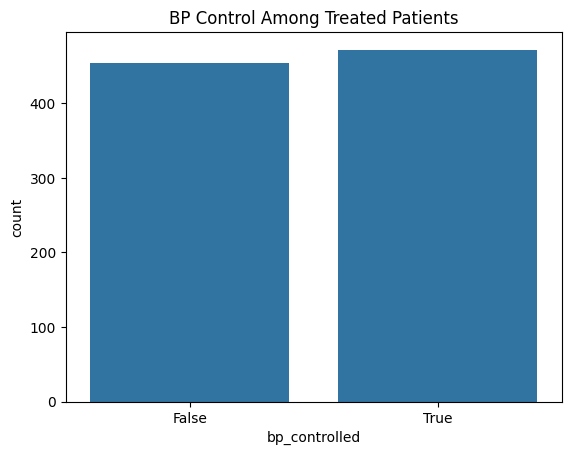

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=treated, x='bp_controlled')
plt.title("BP Control Among Treated Patients")
plt.show()

In [18]:
df['drug_clean'] = df['RXDDRUG'].str.lower().str.strip()

In [19]:
antihypertensives = ['ramipril', 'telmisartan', 'bisoprolol', 'amlodipine', 'chlorthalidone']

treated = df[df['drug_clean'].isin(antihypertensives)].copy()
treated['bp_controlled'] = (treated['BPXOSY1'] < 140) & (treated['BPXODI1'] < 90)

In [20]:
drug_summary = (
    treated.groupby('drug_clean')['bp_controlled']
    .agg(['count', 'sum', 'mean'])
    .rename(columns={'count': 'patients', 'sum': 'controlled', 'mean': 'control_rate'})
    .sort_values('control_rate', ascending=False)
)

print(drug_summary)

                patients  controlled  control_rate
drug_clean                                        
bisoprolol             9           7      0.777778
ramipril              48          32      0.666667
chlorthalidone        46          23      0.500000
amlodipine           728         357      0.490385
telmisartan           21          10      0.476190


/var/folders/bg/4ythw_qj51q7y1b44njv2wx40000gp/T/ipykernel_67902/890215384.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


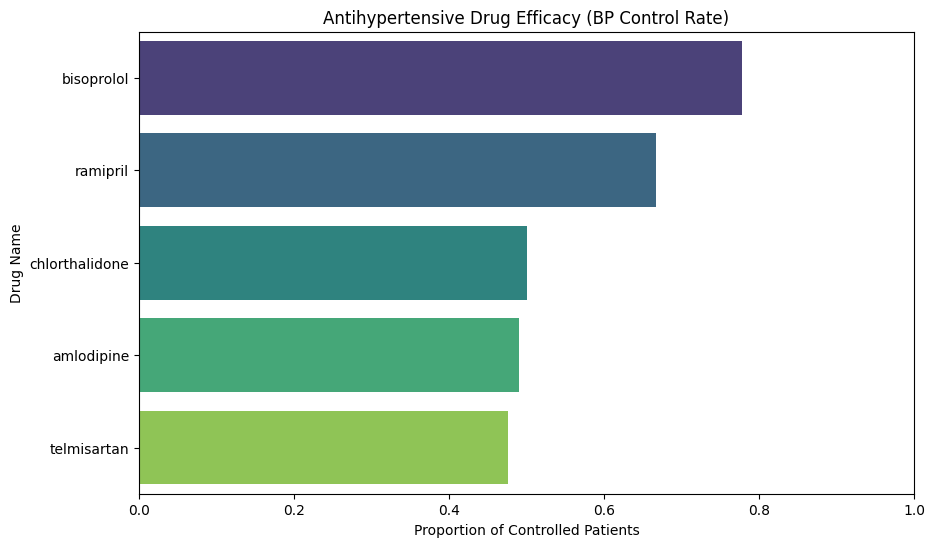

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(
    data=drug_summary.reset_index(),
    x='control_rate', y='drug_clean',
    palette='viridis'
)
plt.title("Antihypertensive Drug Efficacy (BP Control Rate)")
plt.xlabel("Proportion of Controlled Patients")
plt.ylabel("Drug Name")
plt.xlim(0, 1)
plt.show()

In [23]:
plt.savefig("bp_control_by_drug.png", dpi=300, bbox_inches="tight")

<Figure size 640x480 with 0 Axes>